# INTRINSIC VALUE CALCULATOR

1. PORTFOLIO HEALTH CHECK
2. STOCK PE HISTOGRAM
3. STOCK PR DISTRIBUTION
4. PE VS RETURN

In [17]:
import akshare as ak

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if "PingFang" in f.name or "Heiti" in f.name]
plt.rcParams['font.sans-serif'] = ['Heiti TC']

from tqdm import tqdm
from datetime import datetime
import os

## PORTFOLIO HEALTH CHECK
1. portfolio earning = eps ttm x shares
2. portfolio net asset = bps x shares
3. earning yield = portfolio earning / cost
4. net asset yield = portfolio net asset / cost
5. roe = portfolio earning / portfolio net asset

In [6]:
# UPDATE THE DICTIONARY BELOW
investment_dict = {
    '20251212': {
        "stock_code": ["600519", "000858", "600938", "000333", "601088", "300866", "600900"],
        "cost_per_share": [1482.8976, 139.3360, 27.4303, 76.5841, 42.1904, 94.5264, 27.1260], 
        "shares": [100, 700, 2600, 700, 1000, 400, 1200]
    }, 
    '20251220': {
        "stock_code": ["600519", "000858", "600938", "000333", "600926", "300866", "600900"],
        "cost_per_share": [1458.9406, 136.7580, 27.4303, 76.5841, 15.1237, 94.5264, 27.1260], 
        "shares": [100, 700, 2600, 700, 2700, 400, 1200]
    }, 
    '20251222': {
    "stock_code": ["600519", "000858", "600938", "000333", "600926", "300866", "600900", "601128"],
    "cost_per_share": [1458.9406, 136.7580, 27.4299, 76.5841, 15.1237, 94.5264, 27.1260, 7.1919], 
    "shares": [100, 700, 2600, 700, 2700, 400, 1200, 2700]
    }, 
}

# CHANGE THE DATE HERE
portfolio_date = '20251222'

STOCK_CODES = investment_dict[portfolio_date]['stock_code']
STOCK_SYMBOLS_1 = [code + ".SH" if code.startswith("6") else code + ".SZ" for code in STOCK_CODES ]
STOCK_SYMBOLS_2 = ['sh' + code if code.startswith("6") else 'sz' + code for code in STOCK_CODES]
STOCK_SYMBOLS_3 = ['SH' + code if code.startswith("6") else 'SZ' + code for code in STOCK_CODES]

investment_df = pd.DataFrame(investment_dict[portfolio_date])
investment_df

,stock_code,cost_per_share,shares
0,600519,1458.9406,100
1,000858,136.7580,700
2,600938,27.4299,2600
3,000333,76.5841,700
4,600926,15.1237,2700
5,300866,94.5264,400
6,600900,27.1260,1200
7,601128,7.1919,2700


In [7]:
today = datetime.today().strftime('%Y%m%d')

# for season_gap in tqdm(range(12)): # season gap = 0 is the most recent season
dfs = []
for stock_code, symbol in tqdm(zip(STOCK_CODES, STOCK_SYMBOLS_1)):
    # load the eps and roe data
    eps_roe_df = ak.stock_financial_analysis_indicator_em(symbol=symbol, indicator="按报告期")
    eps_roe_df = eps_roe_df[["REPORT_DATE", "REPORT_TYPE", "REPORT_DATE_NAME", 
                            "EPSJB", "BPS", "ROEJQ"]]

    # rename the columns
    eps_roe_df.columns = ["date", "report_type", "report_date_type", "eps", "bps", "roe"]

    # calculate eps ttm
    eps_roe_df['eps_season'] = eps_roe_df['eps'].diff(-1)
    eps_roe_df['eps_season'] = np.where(eps_roe_df['report_type'] == '一季报', 
                                        eps_roe_df['eps'], eps_roe_df['eps_season'])
    eps_roe_df['eps_ttm'] = eps_roe_df['eps_season'].rolling(4).sum().shift(-3)

    # calculate roe ttm
    eps_roe_df['roe_season'] = eps_roe_df['roe'].diff(-1)
    eps_roe_df['roe_season'] = np.where(eps_roe_df['report_type'] == '一季报', 
                                        eps_roe_df['roe'], eps_roe_df['roe_season'])
    eps_roe_df['roe_ttm'] = eps_roe_df['roe_season'].rolling(4).sum().shift(-3)

    # eps_roe_df = eps_roe_df.iloc[season_gap]
    eps_roe_df = eps_roe_df[['date', 'report_type', 'report_date_type', 'eps_ttm', 'bps', 'roe_ttm']]
    eps_roe_df['stock_code'] = symbol[:6]
    eps_roe_df.to_csv(f"../data/input/portfolio/eps_roe_{stock_code}_{portfolio_date}_{today}.csv", index=False)
    dfs.append(eps_roe_df)

0it [00:00, ?it/s]

8it [00:04,  1.70it/s]


In [8]:
portfolio_dfs = []

for season_gap in tqdm(range(12)): # season gap = 0 is the most recent season
    stock_dfs = []
    for df in dfs:
        stock_df = df.iloc[season_gap]
        stock_dfs.append(stock_df)
    stock_dfs = pd.DataFrame(stock_dfs)
    portfolio_df = pd.merge(investment_df, stock_dfs, on='stock_code', how='left', validate="1:1")

    # calculate portfolio metrics
    portfolio_df = portfolio_df.eval("cost = cost_per_share * shares")
    portfolio_df = portfolio_df.eval("porfolio_earning = eps_ttm * shares")
    portfolio_df = portfolio_df.eval("porfolio_net_asset = bps * shares")

    portfolio_df.loc["portfolio", "cost"] = portfolio_df["cost"].sum()
    portfolio_df.loc["portfolio", "porfolio_earning"] = portfolio_df["porfolio_earning"].sum()
    portfolio_df.loc["portfolio", "porfolio_net_asset"] = portfolio_df["porfolio_net_asset"].sum()
    portfolio_df.loc["portfolio", "roe_ttm"] = portfolio_df.loc["portfolio", "porfolio_earning"] / portfolio_df.loc["portfolio", "porfolio_net_asset"] * 100

    portfolio_df = portfolio_df.eval("earning_yield = porfolio_earning / cost")
    portfolio_df = portfolio_df.eval("net_asset_yield = porfolio_net_asset / cost")

    portfolio_df.loc["portfolio", "stock_code"] = "portfolio" + "_season_gap_" + str(season_gap)
    portfolio_df.loc["portfolio", "date"] = portfolio_df.iloc[0, 3] # column 3 is date
    portfolio_df.loc["portfolio", "report_type"] = portfolio_df.iloc[0, 4] # column 4 is report_type

    portfolio_dfs.append(portfolio_df)

portfolio_dfs = pd.concat(portfolio_dfs)
portfolio_dfs.to_csv(f"../data/processed/portfolio/portfolio_intrinsic_value_over_seasons_{portfolio_date}_{today}.csv", index=False)
portfolio_dfs.loc["portfolio"]

100%|██████████| 12/12 [00:00<00:00, 122.11it/s]


,stock_code,cost_per_share,shares,date,report_type,report_date_type,eps_ttm,bps,roe_ttm,cost,porfolio_earning,porfolio_net_asset,earning_yield,net_asset_yield
portfolio,portfolio_season_gap_0,NaN,NaN,2025-09-30 00:00:00,三季报,NaN,NaN,NaN,18.737152,497165.15,37815.08,201818.723241,0.076061,0.405939
portfolio,portfolio_season_gap_1,NaN,NaN,2025-06-30 00:00:00,中报,NaN,NaN,NaN,19.692599,497165.15,38813.01,197094.399467,0.078069,0.396436
portfolio,portfolio_season_gap_2,NaN,NaN,2025-03-31 00:00:00,一季报,NaN,NaN,NaN,19.033371,497165.15,38994.98,204876.895072,0.078435,0.412090
portfolio,portfolio_season_gap_3,NaN,NaN,2024-12-31 00:00:00,年报,NaN,NaN,NaN,19.491262,497165.15,37947.62,194690.420495,0.076328,0.391601
portfolio,portfolio_season_gap_4,NaN,NaN,2024-09-30 00:00:00,三季报,NaN,NaN,NaN,19.413696,497165.15,37158.32,191402.602617,0.074740,0.384988
portfolio,portfolio_season_gap_5,NaN,NaN,2024-06-30 00:00:00,中报,NaN,NaN,NaN,19.796841,497165.15,36134.21,182525.130040,0.072680,0.367132
portfolio,portfolio_season_gap_6,NaN,NaN,2024-03-31 00:00:00,一季报,NaN,NaN,NaN,18.267820,497165.15,34817.32,190593.728410,0.070032,0.383361
portfolio,portfolio_season_gap_7,NaN,NaN,2023-12-31 00:00:00,年报,NaN,NaN,NaN,18.645255,497165.15,33346.78,178848.610517,0.067074,0.359737
portfolio,portfolio_season_gap_8,NaN,NaN,2023-09-30 00:00:00,三季报,NaN,NaN,NaN,19.153203,497165.15,33133.34,172991.122363,0.066645,0.347955
portfolio,portfolio_season_gap_9,NaN,NaN,2023-06-30 00:00:00,中报,NaN,NaN,NaN,19.381287,497165.15,32155.54,165910.245330,0.064678,0.333713


In [9]:
portfolio_cost = portfolio_dfs.loc[portfolio_dfs.stock_code == "portfolio_season_gap_0", "cost"].values[0]
portfolio_earning = portfolio_dfs.loc[portfolio_dfs.stock_code == "portfolio_season_gap_0", "porfolio_earning"].values[0]
portfolio_net_asset = portfolio_dfs.loc[portfolio_dfs.stock_code == "portfolio_season_gap_0", "porfolio_net_asset"].values[0]
portfolio_earning_yield = portfolio_dfs.loc[portfolio_dfs.stock_code == "portfolio_season_gap_0", "earning_yield"].values[0]
portfolio_net_asset_yield = portfolio_dfs.loc[portfolio_dfs.stock_code == "portfolio_season_gap_0", "net_asset_yield"].values[0]
print(portfolio_cost, portfolio_earning, portfolio_net_asset, portfolio_earning_yield, portfolio_net_asset_yield)

497165.15 37815.08 201818.7232408684 0.0760614053499124 0.4059389988233656


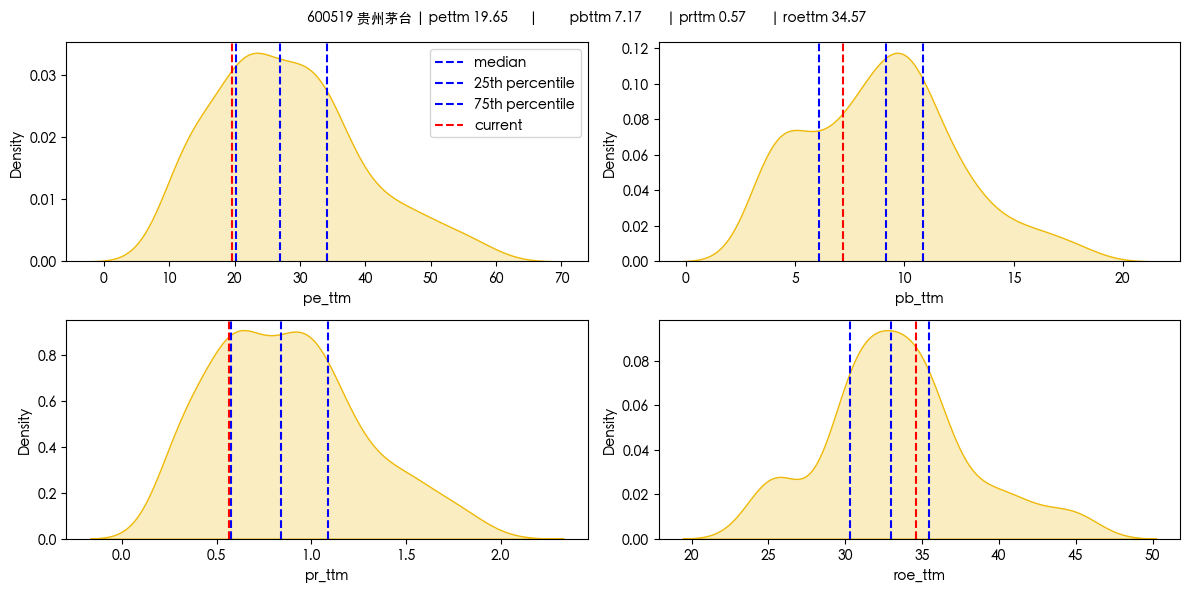

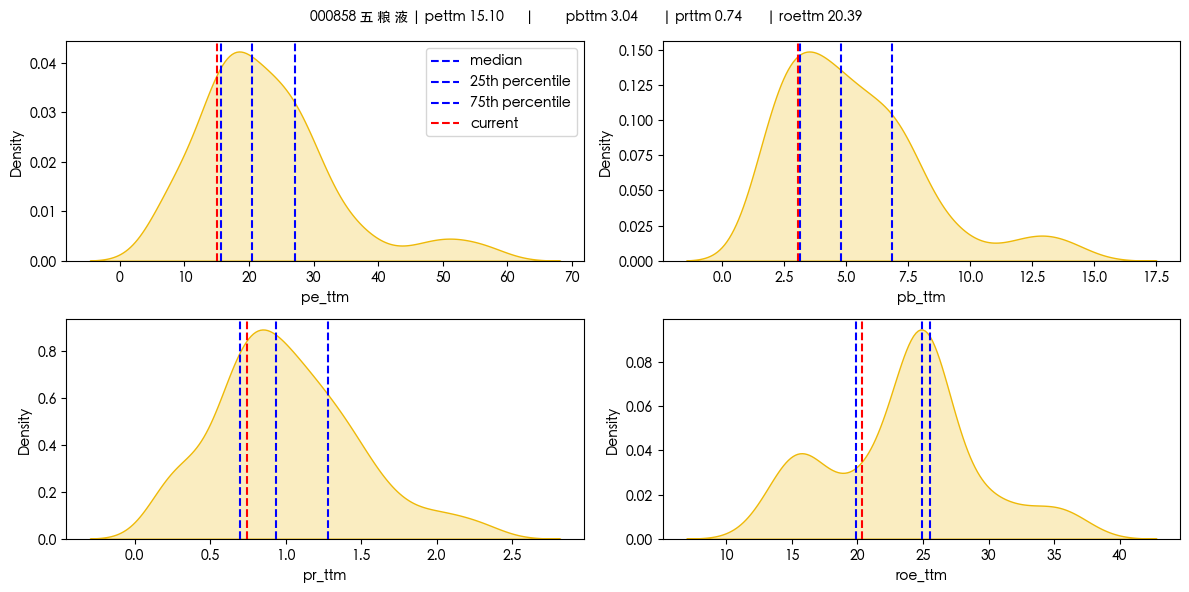

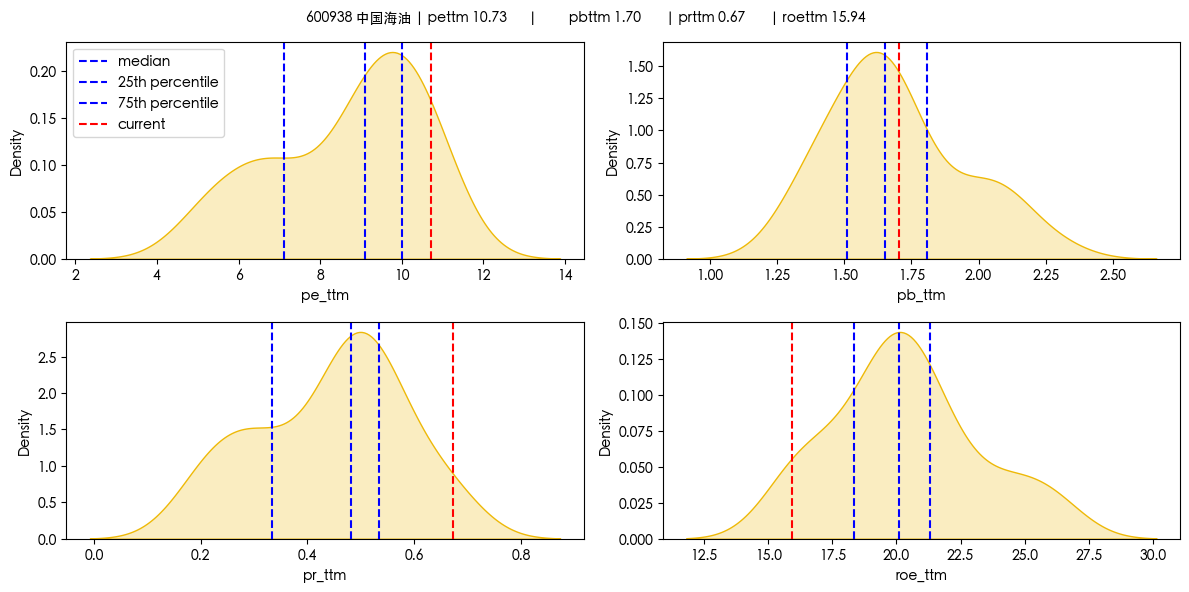

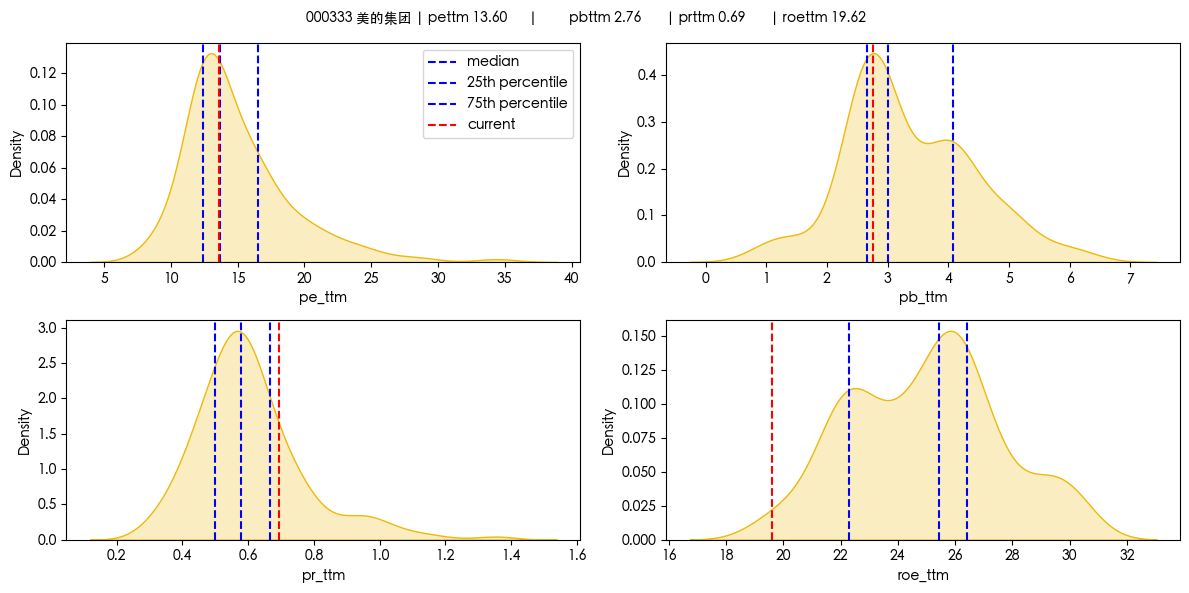

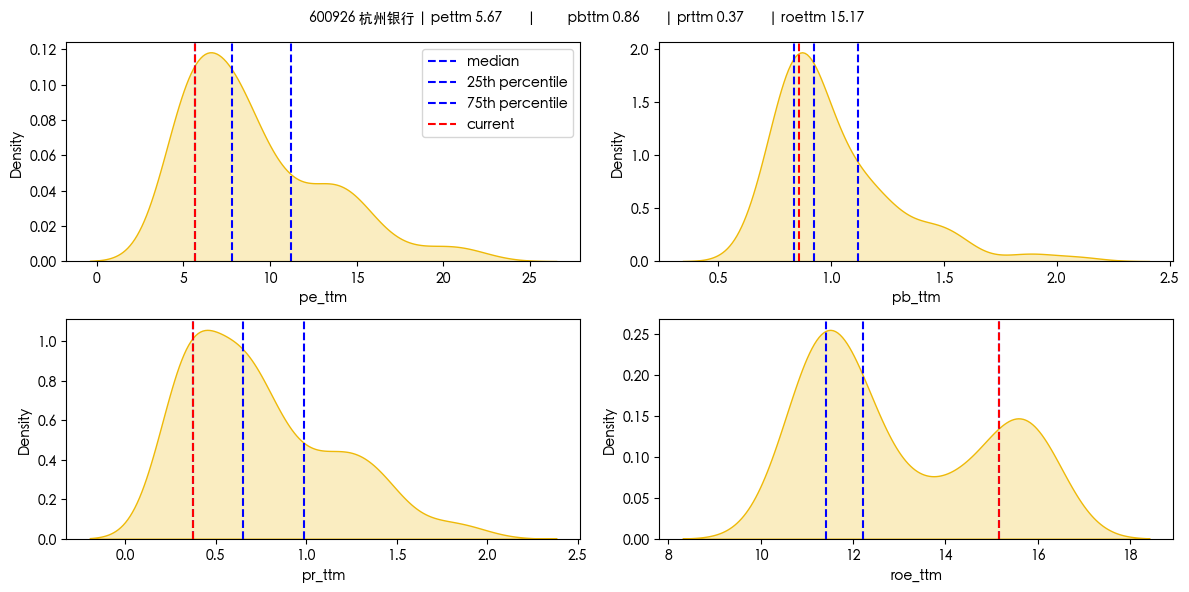

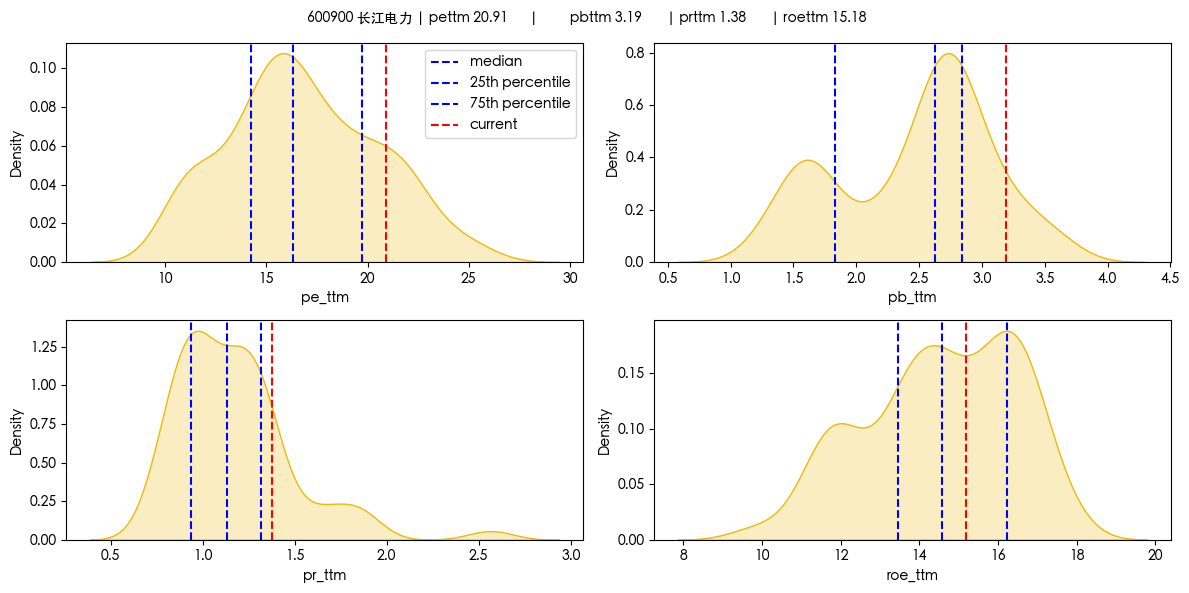

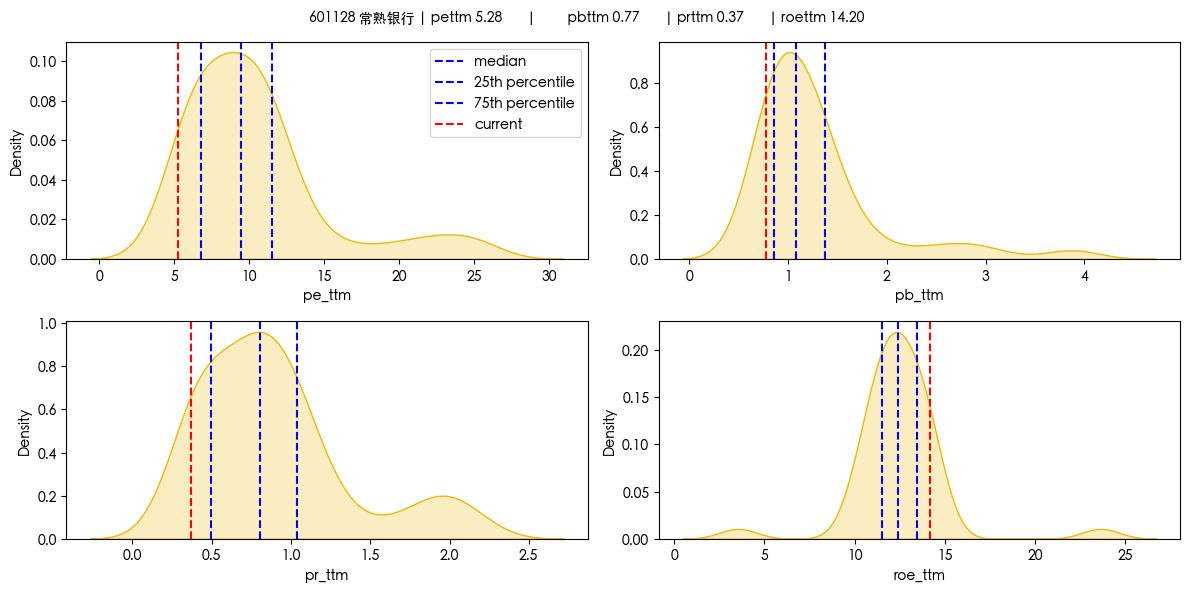

In [24]:
# CHANGE THIS DATE TO PORTFOLIO DATE IN THE WEEKEND
value_date = "20251219"

for stock_code in STOCK_CODES:
    try:
        financial_price = pd.read_csv(f"../data/processed/stock-valuation/{value_date}/stock_valuation_{stock_code}_{value_date}.csv")
    except Exception:
        continue

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()

    # pe ttm distribution
    sns.kdeplot(financial_price, x='pe_ttm', fill=True, color="#eeb908", ax=axes[0])

    # median pettm
    axes[0].axvline(x=financial_price['pe_ttm'].median(), color='blue', linestyle='--', label='median')
    # 25th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.25), color='blue', linestyle='--', label='25th percentile')
    # 75th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.75), color='blue', linestyle='--', label='75th percentile')

    # current pe ttm
    axes[0].axvline(x=financial_price.iloc[-1, -5], color='red', linestyle='--', label='current')
    axes[0].legend()

    # pb ttm distribution
    sns.kdeplot(financial_price, x='pb_ttm', fill=True, color="#eeb908", ax=axes[1])

    # median pbttm
    axes[1].axvline(x=financial_price['pb_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current pb ttm
    axes[1].axvline(x=financial_price.iloc[-1, -4], color='red', linestyle='--')

    # pr ttm distribution
    sns.kdeplot(financial_price, x='pr_ttm', fill=True, color="#eeb908", ax=axes[2])

    # median prttm
    axes[2].axvline(x=financial_price['pr_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current pr ttm
    axes[2].axvline(x=financial_price.iloc[-1, -3], color='red', linestyle='--')

    # roe ttm distribution
    sns.kdeplot(financial_price, x='roe_ttm', fill=True, color="#eeb908", ax=axes[3])

    # median roettm
    axes[3].axvline(x=financial_price['roe_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.75), color='blue', linestyle='--')
    # current roe ttm
    axes[3].axvline(x=financial_price.iloc[-1, -6], color='red', linestyle='--')

    stock_names = pd.read_csv("../data/input/stock_names_full.csv")
    stock_name = stock_names[stock_names['code'] == int(stock_code)]['name'].values[0]
    fig.suptitle(f"{stock_code} {stock_name} | pettm {financial_price.iloc[-1, -5]:<10.2f} | \
        pbttm {financial_price.iloc[-1, -4]:<10.2f} | prttm {financial_price.iloc[-1, -3]:<10.2f} | roettm {financial_price.iloc[-1, -6]:<10.2f}", 
        fontsize=10)
    plt.tight_layout()
    # plt.legend()

    # save the image
    # craete the img/20251213 folder if it doesn't exist
    if not os.path.exists(f"../img/portfolio/{value_date}"):
        os.makedirs(f"../img/portfolio/{value_date}")
    plt.savefig(f"../img/portfolio/{value_date}/pe_pb_pr_roe_distribution_monthly_close_{stock_code}_{value_date}.png", dpi=300)
    plt.show()

## EMAIL SENDER

In [20]:
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.header import Header
from smtplib import SMTP_SSL
from datetime import datetime

import pandas as pd

import os 
from dotenv import load_dotenv

In [29]:
# def send_mail(receiver='', mail_title='', mail_content=''):
#     # ssl login
#     smtp = SMTP_SSL(host_server)
#     # set_debuglevel() for debug, 1 enable debug, 0 for disable
#     # smtp.set_debuglevel(1)
#     smtp.ehlo(host_server)
#     smtp.login(sender_mail, sender_passcode)

#     # construct message
#     msg = MIMEText(mail_content, "plain", 'utf-8')
#     msg["Subject"] = Header(mail_title, 'utf-8')
#     msg["From"] = sender_mail
#     msg["To"] = receiver
#     smtp.sendmail(sender_mail, receiver, msg.as_string())
#     smtp.quit()

def send_mail(receiver='', mail_title='', mail_content='', img_dir=f'../img/portfolio/{value_date}'):
    smtp = SMTP_SSL(host_server)
    smtp.ehlo(host_server)
    smtp.login(sender_mail, sender_passcode)

    # Root message
    msg_root = MIMEMultipart('related')
    msg_root['Subject'] = Header(mail_title, 'utf-8')
    msg_root['From'] = sender_mail
    msg_root['To'] = receiver

    # Alternative (HTML)
    msg_alt = MIMEMultipart('alternative')
    msg_root.attach(msg_alt)

    # Build HTML body
    html = f"""
    <html>
      <body>
        <p>{mail_content}</p>
    """

    # Attach images
    for i, filename in enumerate(os.listdir(img_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            cid = f"img{i}"
            html += f'<p><img src="cid:{cid}" style="max-width:600px;"></p>'

            with open(os.path.join(img_dir, filename), 'rb') as f:
                img = MIMEImage(f.read())
                img.add_header('Content-ID', f'<{cid}>')
                img.add_header('Content-Disposition', 'inline', filename=filename)
                msg_root.attach(img)

    html += """
      </body>
    </html>
    """

    msg_alt.attach(MIMEText(html, 'html', 'utf-8'))

    smtp.sendmail(sender_mail, receiver, msg_root.as_string())
    smtp.quit()

In [30]:
load_dotenv()
today = datetime.now().strftime('%Y%m%d')

# qq mail sending server
host_server = os.getenv("SMTP_SERVER")
sender_mail = os.getenv("SENDER_EMAIL")
sender_passcode = os.getenv("EMAIL_AUTH_CODE")

# receiver mail
receiver = os.getenv("RECEIVER_EMAIL")
# mail title
mail_title = f'Portfolio Intrinsic Value by {portfolio_date}'
# mail contents
mail_content = f'The portfolio intrinsic value by {portfolio_date} are: \n' + \
f'portfolio_cost: {portfolio_cost} \n' + \
f'portfolio_earning: {portfolio_earning} \n' + \
f'portfolio_net_asset: {portfolio_net_asset} \n' + \
f'portfolio_earning_yield: {portfolio_earning_yield} \n' + \
f'portfolio_net_asset_yield: {portfolio_net_asset_yield} \n'

send_mail(receiver=receiver,mail_title=mail_title,mail_content=mail_content, img_dir=f"../img/portfolio/{value_date}")
print('Email sent successfully.')

Email sent successfully.
